In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [20]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [21]:
def potential(x,k,l,scale=100):

    x=100-x
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [22]:
def potential_2(x,k,l,scale=100):

    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [23]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [24]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01


In [25]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print(eigenvalues[:en_num+extend_num])

tensor([-5.0551e+01, -1.3759e+01, -6.8471e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8012e+00, -1.5241e+00, -1.2848e+00,
        -1.0719e+00, -8.7945e-01, -7.0394e-01, -5.4351e-01, -3.9735e-01,
        -3.1254e-01, -2.6559e-01, -2.6183e-01, -2.1228e-01, -1.6615e-01,
        -1.4923e-01, -1.2229e-01, -8.1992e-02, -5.4613e-02, -5.1735e-02,
        -4.5181e-02, -1.4592e-02,  4.1959e-03,  1.3283e-02,  2.7473e-02,
         4.6256e-02,  6.6757e-02,  8.9039e-02,  1.1249e-01,  1.3802e-01,
         1.6320e-01,  1.9150e-01,  2.2069e-01,  2.5132e-01,  2.8267e-01],
       device='cuda:2')


In [26]:
V_diag=potential_2(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en_2=eigenvalues[:en_num].detach()
print(eigenvalues[:en_num+extend_num])

tensor([-5.0551e+01, -1.3759e+01, -6.8472e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8014e+00, -1.5234e+00, -1.2848e+00,
        -1.0722e+00, -8.7943e-01, -7.0419e-01, -5.4242e-01, -3.9783e-01,
        -3.1259e-01, -2.6561e-01, -2.6173e-01, -2.1234e-01, -1.6620e-01,
        -1.4930e-01, -1.2218e-01, -8.1936e-02, -5.4660e-02, -5.2069e-02,
        -4.5128e-02, -1.4405e-02,  4.0138e-03,  1.3537e-02,  2.6757e-02,
         4.6240e-02,  6.7044e-02,  8.8982e-02,  1.1245e-01,  1.3746e-01,
         1.6365e-01,  1.9150e-01,  2.2076e-01,  2.5125e-01,  2.8285e-01],
       device='cuda:2')


tensor([-8.6026e-06, -1.4764e-05, -8.7746e-06, -2.7050e-06, -5.9403e-06,
        -9.9582e-06, -2.6527e-05, -9.0197e-05,  4.4808e-04, -3.6742e-05,
        -2.3627e-04,  1.8435e-05, -3.4568e-04,  2.0270e-03, -1.1877e-03,
        -1.6380e-04, -6.8557e-05,  3.7188e-04, -2.9137e-04, -2.9193e-04,
        -5.1699e-04,  8.5194e-04,  6.8399e-04, -8.4872e-04, -6.4043e-03,
         1.1734e-03,  1.3026e-02,  4.5390e-02, -1.8753e-02,  2.6757e-02],
       device='cuda:2')


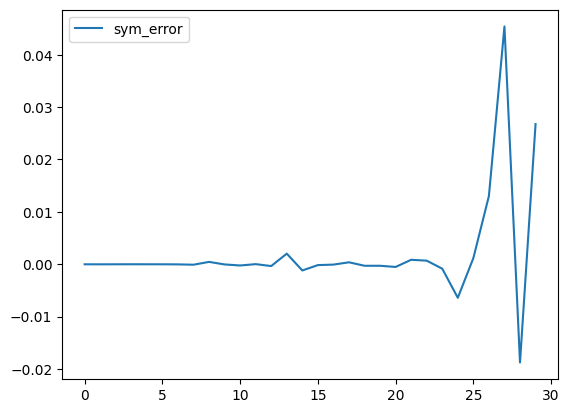

In [29]:
sym_error=(real_en-real_en_2)/real_en_2
print(sym_error)
plt.plot(sym_error.cpu().numpy(),label='sym_error')
plt.legend()
plt.show()


In [7]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:2.818495035171509,time:0.23538970947265625,lr:0.01

epoch: 0
tensor([-0.8178, -0.7600, -0.7117, -0.6680, -0.6274, -0.5888, -0.5519, -0.5161,
        -0.4813, -0.4474, -0.4141, -0.3815, -0.3494, -0.3179, -0.2866, -0.2559,
        -0.2257, -0.1953, -0.1666, -0.1381, -0.1094, -0.0818, -0.0544, -0.0286,
        -0.0040,  0.0196,  0.0395,  0.0569,  0.0778,  0.1014], device='cuda:2',
       grad_fn=<SliceBackward0>)
tensor([-5.0551e+01, -1.3759e+01, -6.8471e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8012e+00, -1.5241e+00, -1.2848e+00,
        -1.0719e+00, -8.7945e-01, -7.0394e-01, -5.4351e-01, -3.9735e-01,
        -3.1254e-01, -2.6559e-01, -2.6183e-01, -2.1228e-01, -1.6615e-01,
        -1.4923e-01, -1.2229e-01, -8.1992e-02, -5.4613e-02, -5.1735e-02,
        -4.5181e-02, -1.4592e-02,  4.1959e-03,  1.3283e-02,  2.7473e-02],
       device='cuda:2')
epoch:10,loss:2.7918009757995605,time:1.2695486545562744,lr:0.01

epoch: 10
tensor([-2.0399, -1.7601, -1.5440,

In [8]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

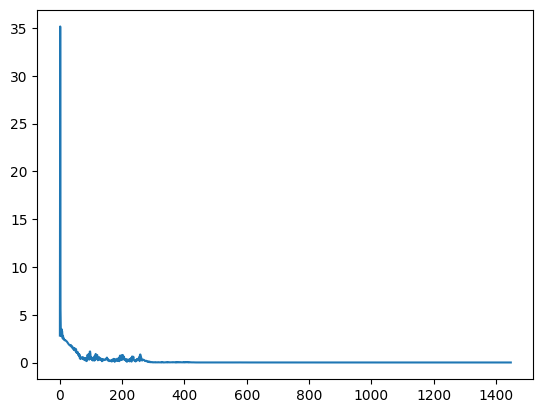

In [9]:
plt.plot(loss_list)
plt.show()

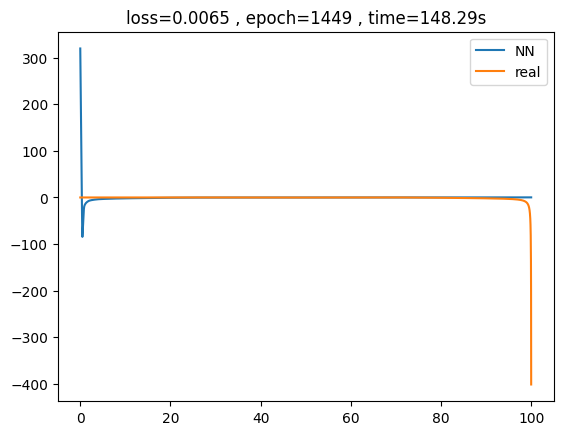

In [15]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


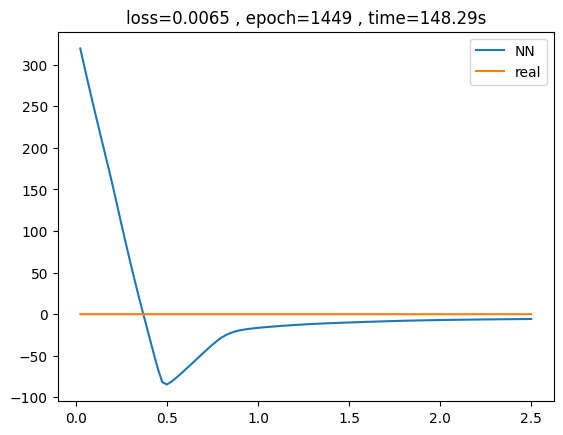

In [11]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [12]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([-9.9182e-05, -2.2888e-05,  4.7207e-05, -9.0599e-06,  2.0875e-02,
        -8.4722e-03,  8.7261e-05,  7.8511e-04, -5.9593e-04, -1.6564e-03,
        -1.9166e-03,  7.0989e-05,  3.6434e-03,  3.8067e-03, -1.1450e-02,
        -7.4951e-03,  2.3186e-05,  3.4277e-02,  1.4920e-02, -3.8512e-03,
         5.1184e-03,  9.8783e-04, -1.7645e-02, -2.3473e-02, -6.1093e-03,
         7.1014e-03, -4.3984e-03, -4.7316e-03,  4.3401e-03,  8.0957e-03],
       device='cuda:2', grad_fn=<SubBackward0>)
relative error: tensor([ 1.9620e-06,  1.6635e-06, -6.8944e-06,  2.0558e-06, -6.4212e-03,
         3.2766e-03, -4.0794e-05, -4.3587e-04,  3.9101e-04,  1.2893e-03,
         1.7880e-03, -8.0720e-05, -5.1757e-03, -7.0039e-03,  2.8815e-02,
         2.3982e-02, -8.7301e-05, -1.3091e-01, -7.0284e-02,  2.3179e-02,
        -3.4299e-02, -8.0780e-03,  2.1521e-01,  4.2979e-01,  1.1809e-01,
        -1.5718e-01,  3.0142e-01, -1.1277e+00,  3.2675e-01,  2.9468e-01],
       device='cuda:2', grad_fn=<DivBackward0

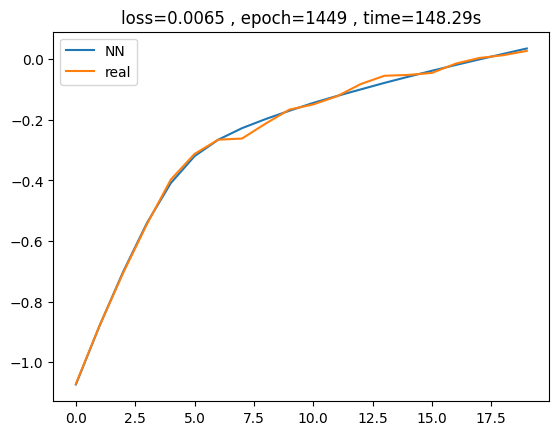

In [13]:
plt.plot(output[10:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[10:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

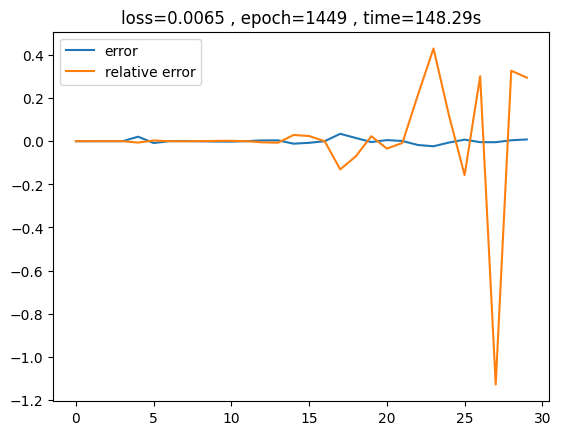

In [14]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()